Import Libraries

In [381]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go


In [382]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import mean_squared_error
import numpy as np

In [383]:
df = pd.read_csv('data/enhanced_train.csv')
df_test = pd.read_csv('data/enhanced_test.csv')

In [384]:
# Drop columns not needed for training
drop_cols = ['Unnamed: 0', 'Item_Outlet_Sales','Log_Sales','Item_Identifier']
X = df.drop(columns=drop_cols)
y = df['Log_Sales']  # Use log-transformed target


In [385]:
# 'Freq_Bin_Item_Cluster' is string (required by splitter)
df['Freq_Bin_Item_Cluster'] = df['Freq_Bin_Item_Cluster'].astype(str)

# Stratified Split
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, val_idx in splitter.split(df, df['Freq_Bin_Item_Cluster']):
    df_train_split = df.iloc[train_idx].copy()
    df_val_split = df.iloc[val_idx].copy()


In [386]:
# Separate features and target
X_train = df_train_split.drop(columns=['Item_Outlet_Sales', 'Log_Sales','Unnamed: 0','Outlet_Identifier','Item_Identifier','Freq_Bin_Item_Cluster'])
y_train = df_train_split['Log_Sales']

X_val = df_val_split.drop(columns=['Item_Outlet_Sales', 'Log_Sales','Unnamed: 0','Outlet_Identifier','Item_Identifier','Freq_Bin_Item_Cluster'])
y_val = df_val_split['Log_Sales']


In [387]:
X_train.to_csv('data/final_train.csv')
X_val.to_csv('data/final_test.csv')


In [388]:
X_train.columns

Index(['Item_Code', 'Item_Type', 'Item_Fat_Content', 'Item_Type_Cluster',
       'Is_Misc_Item', 'Item_MRP', 'Item_Profile', 'Outlet_Type', 'Outlet_Age',
       'Item_Profile_Freq_Bin', 'Median_Log_Sales_ItemCluster_OutletType',
       'Median_Log_Sales_per_Outlet', 'Median_Log_Sales_per_Item_Cluster',
       'Median_Log_Sales_per_ItemProfile_OutletType', 'MRP_per_Year',
       'Median_Log_Sales_Per_City_Tier', 'Median_MRP_ItemType_Per_Tier',
       'MRP_Deviation_From_Tier_Median', 'Abs_MRP_Deviation',
       'Median_Log_Sales_per_Item_OutletType',
       'Median_Sales_per_Item_OutletType'],
      dtype='object')

In [389]:

# Sanity check: No missing profiles
train_profiles = set(df.loc[X_train.index, 'Item_Profile'])
val_profiles = set(df.loc[X_val.index, 'Item_Profile'])
missing_profiles = val_profiles - train_profiles
if missing_profiles:
    print(f"Warning: Some item profiles are only in validation: {missing_profiles}")

In [390]:

# One-hot encode categoricals
X_train_encoded = pd.get_dummies(X_train)
X_val_encoded = pd.get_dummies(X_val)

Type 1 - Training

In [391]:
# Align columns for both sets
X_train_encoded, X_val_encoded = X_train_encoded.align(X_val_encoded, join='left', axis=1, fill_value=0)

# # Train XGBoost model
# model = XGBRegressor(
#     n_estimators=300,
#     learning_rate=0.05,
#     max_depth=6,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     random_state=42,
#     n_jobs=-1,
#     early_stopping_rounds=100,
# )

model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,          # enough trees to capture complexity
    learning_rate=0.01,        # small step to generalize better
    max_depth=6,               # reasonable depth, avoids overfitting
    subsample=0.8,             # row sampling to reduce variance
    colsample_bytree=0.8,      # column sampling to reduce feature noise
    min_child_weight=3,        # control splits with small data
    gamma=0.1,                 # penalize unnecessary splits
    reg_alpha=0.7,             # L1 regularization (sparsity)
    reg_lambda=1.5,            # L2 regularization (stability)
    n_jobs=-1,
    random_state=42
)

model.fit(
    X_train_encoded, y_train,
    eval_set=[(X_val_encoded, y_val)],
    verbose=True
)

# 🔹 6. Evaluate model
y_val_pred_log = model.predict(X_val_encoded)
y_val_pred = np.expm1(y_val_pred_log)  # inverse of log1p
y_val_true = np.expm1(y_val)

rmse = np.sqrt(mean_squared_error(y_val_true, y_val_pred))
print(f"\n Validation RMSE (after inverse log transform): {rmse:.4f}")


[0]	validation_0-rmse:0.98524
[1]	validation_0-rmse:0.97808
[2]	validation_0-rmse:0.97096
[3]	validation_0-rmse:0.96397
[4]	validation_0-rmse:0.95715
[5]	validation_0-rmse:0.95033
[6]	validation_0-rmse:0.94367
[7]	validation_0-rmse:0.93701
[8]	validation_0-rmse:0.93043
[9]	validation_0-rmse:0.92394
[10]	validation_0-rmse:0.91764
[11]	validation_0-rmse:0.91135
[12]	validation_0-rmse:0.90507
[13]	validation_0-rmse:0.89899
[14]	validation_0-rmse:0.89302
[15]	validation_0-rmse:0.88695
[16]	validation_0-rmse:0.88108
[17]	validation_0-rmse:0.87536
[18]	validation_0-rmse:0.86960
[19]	validation_0-rmse:0.86394
[20]	validation_0-rmse:0.85835
[21]	validation_0-rmse:0.85290
[22]	validation_0-rmse:0.84740
[23]	validation_0-rmse:0.84203
[24]	validation_0-rmse:0.83677
[25]	validation_0-rmse:0.83155
[26]	validation_0-rmse:0.82645
[27]	validation_0-rmse:0.82142
[28]	validation_0-rmse:0.81646
[29]	validation_0-rmse:0.81162
[30]	validation_0-rmse:0.80673
[31]	validation_0-rmse:0.80204
[32]	validation_0-

In [392]:
X_test = pd.get_dummies(df_test.drop(columns=['Item_Identifier', 'Outlet_Identifier']))
X_test = X_test.reindex(columns=X_train_encoded.columns, fill_value=0)

test_preds_log = model.predict(X_test)
test_preds = np.expm1(test_preds_log)

# Save predictions
submission = df_test[['Item_Identifier', 'Outlet_Identifier']].copy()
submission['Item_Outlet_Sales'] = test_preds
submission.to_csv('xgb_3_submission.csv', index=False)


Feature Importance - Analysis

In [393]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Sample some rows for speed
X_sample = X_val_encoded.sample(500, random_state=42)

# Create SHAP explainer from trained XGBoost model
explainer = shap.Explainer(model)

# Compute SHAP values
shap_values = explainer(X_sample)


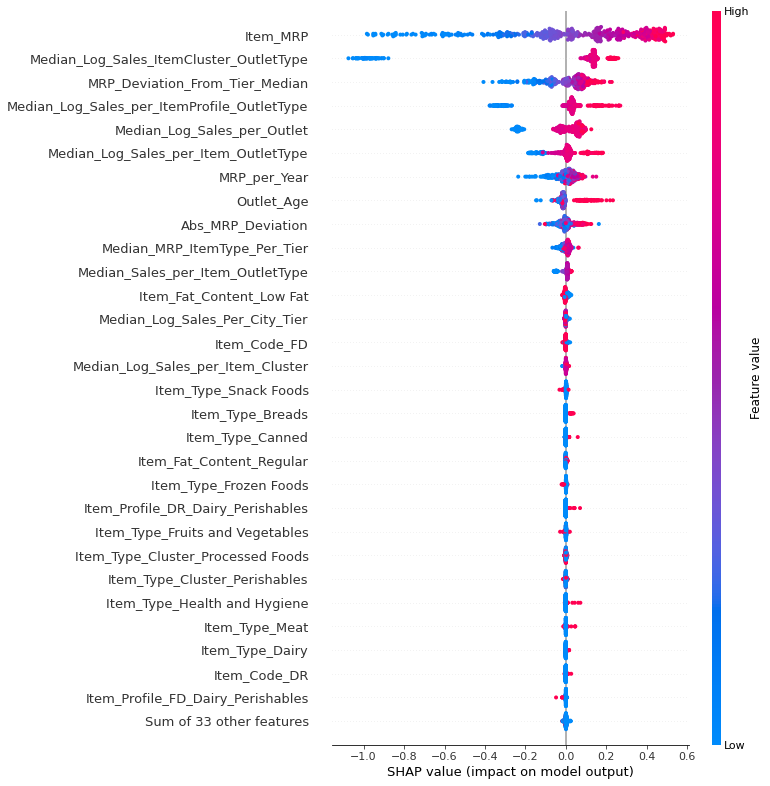

In [394]:
shap.plots.beeswarm(shap_values, max_display=30)


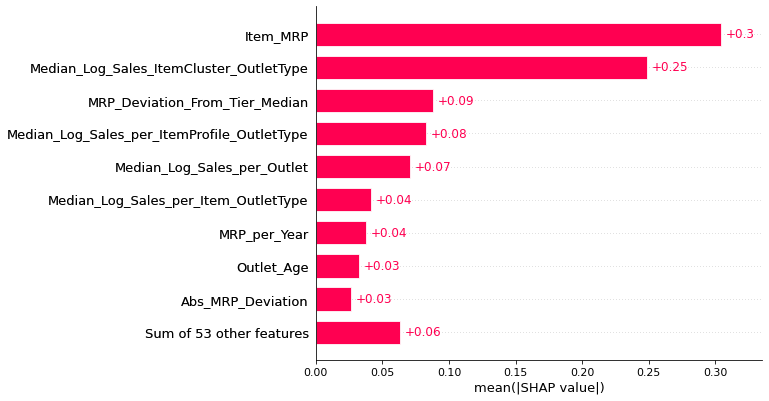

In [395]:
shap.plots.bar(shap_values)


In [396]:
# Calculate mean absolute SHAP values per feature
shap_importance = np.abs(shap_values.values).mean(axis=0)

# Create a DataFrame with feature names and their importance
shap_df = pd.DataFrame({
    'Feature': X_val_encoded.columns,
    'Mean_SHAP_Importance': shap_importance
})

# Sort by importance
shap_df = shap_df.sort_values(by='Mean_SHAP_Importance', ascending=False)

# Display top 20
print(shap_df.head(20))


                                        Feature  Mean_SHAP_Importance
1                                      Item_MRP              0.303871
3       Median_Log_Sales_ItemCluster_OutletType              0.248451
10               MRP_Deviation_From_Tier_Median              0.088371
6   Median_Log_Sales_per_ItemProfile_OutletType              0.082731
4                   Median_Log_Sales_per_Outlet              0.070861
12         Median_Log_Sales_per_Item_OutletType              0.041645
7                                  MRP_per_Year              0.037815
2                                    Outlet_Age              0.032810
11                            Abs_MRP_Deviation              0.026219
9                  Median_MRP_ItemType_Per_Tier              0.013568
13             Median_Sales_per_Item_OutletType              0.013043
33                     Item_Fat_Content_Low Fat              0.006060
8                Median_Log_Sales_Per_City_Tier              0.002076
15                  

In [397]:
list(shap_df['Feature'])

['Item_MRP',
 'Median_Log_Sales_ItemCluster_OutletType',
 'MRP_Deviation_From_Tier_Median',
 'Median_Log_Sales_per_ItemProfile_OutletType',
 'Median_Log_Sales_per_Outlet',
 'Median_Log_Sales_per_Item_OutletType',
 'MRP_per_Year',
 'Outlet_Age',
 'Abs_MRP_Deviation',
 'Median_MRP_ItemType_Per_Tier',
 'Median_Sales_per_Item_OutletType',
 'Item_Fat_Content_Low Fat',
 'Median_Log_Sales_Per_City_Tier',
 'Item_Code_FD',
 'Median_Log_Sales_per_Item_Cluster',
 'Item_Type_Snack Foods',
 'Item_Type_Breads',
 'Item_Type_Canned',
 'Item_Fat_Content_Regular',
 'Item_Type_Frozen Foods',
 'Item_Profile_DR_Dairy_Perishables',
 'Item_Type_Fruits and Vegetables',
 'Item_Type_Cluster_Processed Foods',
 'Item_Type_Cluster_Perishables',
 'Item_Type_Health and Hygiene',
 'Item_Type_Meat',
 'Item_Type_Dairy',
 'Item_Code_DR',
 'Item_Profile_FD_Dairy_Perishables',
 'Item_Type_Household',
 'Item_Type_Baking Goods',
 'Outlet_Type_Supermarket Type1',
 'Item_Code_NC',
 'Item_Type_Soft Drinks',
 'Item_Profile_FD_S

SHAP Score of a specific Feature

In [398]:
# import shap
# import pandas as pd

# # Suppose shap_values is already calculated using shap.TreeExplainer
# shap_values = explainer.shap_values(X_train_encoded)

# # Convert to DataFrame
# shap_df = pd.DataFrame(shap_values, columns=X_train_encoded.columns)

# # Get mean absolute SHAP value for a specific feature
# feature = 'Outl'
# mean_shap = shap_df[feature].abs().mean()

# print(f"Mean SHAP value for {feature}: {mean_shap:.5f}")


In [399]:
categorical_columns = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
# print(categorical_columns)

for col in categorical_columns:
    train_vals = set(X_train[col].dropna().unique())
    test_vals = set(X_val[col].dropna().unique())
    diff = test_vals - train_vals
    if diff:
        print(f"New values in test for '{col}': {diff}")
